In [11]:
from __future__ import annotations
from typing import Optional, Tuple, Dict, Any

import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt


# %%
class TinyMaze3x3(gym.Env):
    """A tiny 3x3 maze with hardcoded walls. Keep it simple.

    Start=(0,0), Goal=(2,2), Walls={(1,1),(1,0)}
    Observation: int in [0..8] (r*3 + c)
    Actions: 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT
    """

    metadata = {"render_modes": ["ansi", "human", "rgb_array"]}

    UP, RIGHT, DOWN, LEFT = 0, 1, 2, 3

    def __init__(self, render_mode: Optional[str] = None):
        super().__init__()
        self.n = 3
        self.start = (0, 0)
        self.goal = (2, 2)
        self.walls = {(1, 1), (1, 0)}  # <— edit these if you want
        self.max_steps = 10

        # There are 4 unique actions / Only one can be chosen at any time
        self.action_space = spaces.Discrete(4)
        # The game state is a single number up to n**2
        self.observation_space = spaces.Discrete(self.n * self.n)

        self.render_mode = render_mode
        self.agent_pos = self.start
        self.step_count = 0

    # ---- helpers ----
    # Simply returns encoding of the position in the maze
    def _to_obs(self, pos: Tuple[int, int]) -> int:
        r, c = pos
        return r * self.n + c

    def _in_bounds(self, r: int, c: int) -> bool:
        return 0 <= r < self.n and 0 <= c < self.n

    def _move(self, action: int, pos: Tuple[int, int]) -> Tuple[Tuple[int, int], bool]:
        r, c = pos
        if action == self.UP:
            cand = (r - 1, c)
        elif action == self.RIGHT:
            cand = (r, c + 1)
        elif action == self.DOWN:
            cand = (r + 1, c)
        elif action == self.LEFT:
            cand = (r, c - 1)
        else:
            return pos, False
        if self._in_bounds(*cand) and cand not in self.walls:
            return cand, True
        return pos, False

    # ---- core API ----
    # Same as ml-agents OnEpisodeStart();
    # Goal here is to clean and reset all the environment
    def reset(
        self, *, seed: Optional[int] = None, options: Optional[Dict[str, Any]] = None
    ):
        super().reset(seed=seed)
        # Reposition agent to starting cells
        self.agent_pos = self.start
        # Reset step counter
        self.step_count = 0
        # Returning game state + info (useless for now, but you can use it to create some nice analysis)
        return self._to_obs(self.agent_pos), {"pos": self.agent_pos, "goal": self.goal}

    def step(self, action: int):
        assert self.action_space.contains(action)
        self.step_count += 1

        new_pos, moved = self._move(action, self.agent_pos)
        self.agent_pos = new_pos

        reward = -0.01
        if not moved:
            reward += -0.05

        terminated = self.agent_pos == self.goal
        truncated = (self.step_count >= self.max_steps) and not terminated

        obs = self._to_obs(self.agent_pos)
        info = {"pos": self.agent_pos, "moved": moved, "step": self.step_count}
        if terminated:
            reward += 1.0
        return obs, reward, terminated, truncated, info

    def render(self):
        fig, ax = plt.subplots(figsize=(3, 3))
        ax.set_xlim(-0.5, self.n - 0.5)
        ax.set_ylim(-0.5, self.n - 0.5)
        ax.set_xticks(range(self.n))
        ax.set_yticks(range(self.n))
        ax.grid(True)
        ax.invert_yaxis()

        # Draw walls
        for r, c in self.walls:
            ax.add_patch(plt.Rectangle((c - 0.5, r - 0.5), 1, 1))

        # Draw start, goal, agent
        sr, sc = self.start
        gr, gc = self.goal
        ar, ac = self.agent_pos
        ax.text(sc, sr, "S", ha="center", va="center", fontsize=16, color="green")
        ax.text(gc, gr, "G", ha="center", va="center", fontsize=16, color="red")
        ax.text(ac, ar, "A", ha="center", va="center", fontsize=16, color="blue")

        if self.render_mode == "human":
            # Video like rendering
            # Jupyter-friendly update
            from IPython.display import display, clear_output

            clear_output(wait=True)
            display(fig)
            plt.close(fig)
            return None
        else:
            plt.close(fig)
            return fig

    def close(self):
        pass

In [12]:
env = TinyMaze3x3(render_mode="human")
# Obs contains the game state (which is also the NN/Agent input 99.99% of the times)
obs, info = env.reset(seed=0)
# Done keeps track of whether the game is done or not
done = False

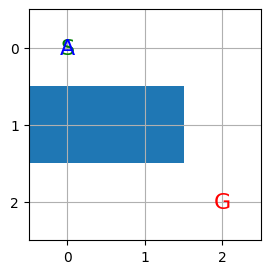

In [13]:
# This renders the env
env.render()

In [14]:
# Game state (we are in cell (0,0))
print(obs)

0


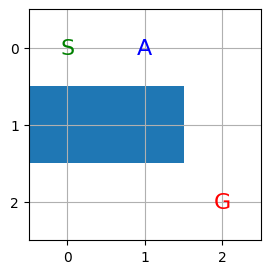

In [15]:
# With env.step(action) you apply actions to the env
obs, reward, terminated, truncated, info = env.step(env.RIGHT)
env.render()

In [16]:
# New state
print(obs)

1


In [17]:
# Reward is -0.01 because we did not reach a target and did not do an invalid action
print(reward)

-0.01


In [18]:
# The env is not done yet
print(done)

False


In [19]:
# Action space are stored in env.action_space
print(env.action_space)
# Print a random action
print(env.action_space.sample())

Discrete(4)
0


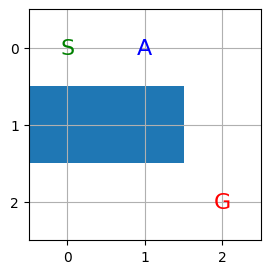

In [26]:
env = TinyMaze3x3(render_mode="human")
# Obs contains the game state (which is also the NN/Agent input 99.99% of the times)
obs, info = env.reset(seed=0)
# Done keeps track of whether the game is done or not
done = False
#
while not done:
    # try a random policy
    a = env.action_space.sample()
    print(a)
    obs, reward, terminated, truncated, info = env.step(a)
    done = terminated or truncated
    env.render()
env.close()